# Проект "Прогнозирование количества заказов такси"

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час, построив модель для такого предсказания.

## План выполнения проекта

1. [**Загрузите данные и выполните их ресемплирование по одному часу.**](#step1) Данные находятся в файле <i>/datasets/taxi.csv</i>.
1. [**Проанализируйте данные.**](#step2)
1. [**Обучите разные модели с различными гиперпараметрами.**](#step3) Сделайте тестовую выборку размером 10% от исходных данных.
1. [**Проверьте данные на тестовой выборке и сделайте выводы.**](#step4)

## Описание данных

- `num_orders` — количество заказов, <i>целевой признак</i>.

## <a name='step1'></a>Шаг 1. Загрузите данные и выполните их ресемплирование по одному часу

Для начала сделаем импорт всех необходимых библиотек.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose as decomp
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

Теперь загрузим данные, записав их в одноименную переменную `taxi`.

In [2]:
try:
    taxi = pd.read_csv('/Users/andreykol/PycharmProjects/Yandex.Praktikum-projects/project_Time_Series/taxi.csv')
    #taxi = pd.read_csv('/datasets/taxi.csv')
except:
    print('Ошибка при загрузке файла!')

Кратко просмотрим имеющиеся данные.

In [3]:
print(taxi.info())
print(taxi.columns)
display(taxi.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None
Index(['datetime', 'num_orders'], dtype='object')


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Итак, столбец с датой имеет тип данных `object`, его нужно изменить на подходящий дате и времени, а также сделать его индексом в таблице. Пропусков в данных нет. Видим, что данные поступают с частотой в 10 минут, сделаем ресемплирование по одному часу, `sum()` будет агрегирующей функцией данных, ведь количество заказов за час является именно суммой количеств заказов за каждые 10 минут этого часа.

In [4]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
taxi = taxi.set_index('datetime')
taxi = taxi.resample('1H').sum()
display(taxi.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## <a name='step2'></a>Шаг 2. Проанализируйте данные

Проверим, является ли индекс монотонным.

In [5]:
taxi.index.is_monotonic

True

Отлично, индекс монотонно возрастает. Выведем информацию о заказах графически.

<AxesSubplot:xlabel='datetime'>

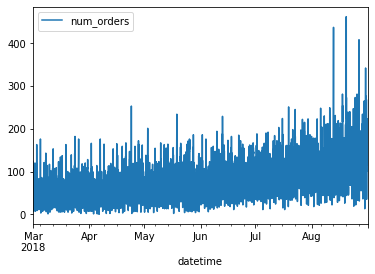

In [6]:
taxi.plot()

На этом этапе мы мало что можем сказать о динамике количества заказов. Разложим временной ряд на тренд, сезонность и остаток, построим их графики и изучим их отдельно друг от друга.

In [7]:
dec_taxi = decomp(taxi)

Сначала выделим тренд и проанализируем его.

<AxesSubplot:xlabel='datetime'>

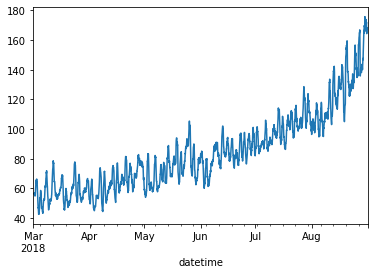

In [8]:
dec_taxi.trend.plot()

Теперь довольно точно вырисовывается тенденция к росту количества заказов. Далее изучим сезонную составляющую.

<AxesSubplot:xlabel='datetime'>

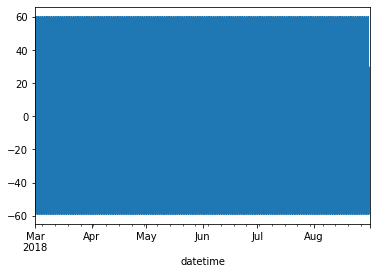

In [9]:
dec_taxi.seasonal.plot()

Ничего неясно. Судя по всему, наша сезонность проявляется на коротких отрезках времени. Рассмотрим произвольный 7-дневный период.

<AxesSubplot:xlabel='datetime'>

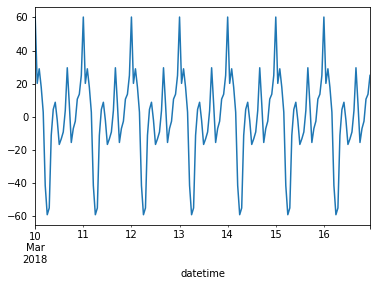

In [10]:
dec_taxi.seasonal['2018-03-10':'2018-03-16'].plot()

Итак, мы видим очевидную периодичность в 1 сутки. Приблизим график еще, чтобы увидеть, какие изменения проходят в течение дня.

<AxesSubplot:xlabel='datetime'>

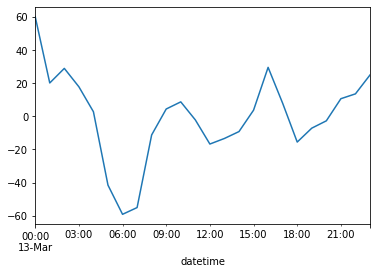

In [11]:
dec_taxi.seasonal['2018-03-13'].plot()

Результаты вполне логичны: ночью, когда не работает общественный транспорт, спрос на такси высок. Затем общественный транспорт начинает свою работу и "отыгрывает" позиции у таксистов.

Наконец, рассмотрим график остатков. Мы ожидаем увидеть "белый шум": значения с нулевым средним и постоянной дисперсией.

<AxesSubplot:xlabel='datetime'>

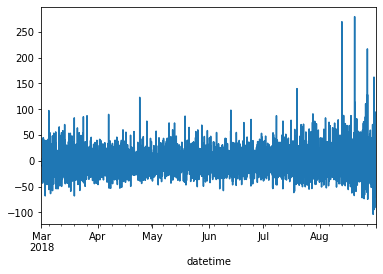

In [12]:
dec_taxi.resid.plot()

В целом, наши ожидания оправдались. Но в августе есть выбросы (например, со значением выше 250, тогда как обычно значения по модулю не превосходят 100). Узнаем, когда они были и почему случились.

<AxesSubplot:xlabel='datetime'>

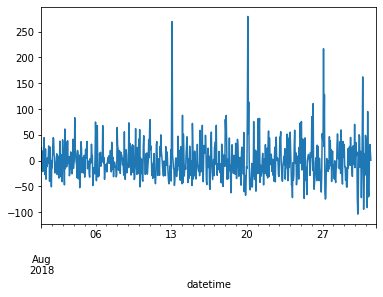

In [13]:
dec_taxi.resid['2018-08'].plot()

Выбросы наблюдаются в ночь с воскресенья на понедельник (три недели подряд). Но строго это, вообще говоря, объяснить нельзя.

## <a name='step3'></a>Шаг 3. Обучите разные модели с различными гиперпараметрами

На этом этапе мы "вычленим" из данных некоторые признаки, которые потом будут использовать наши модели для обучения и предсказания. У нас решается задача регрессии. Будем использовать следующие модели: классическую линейную регрессию, регуляризованную линейную регрессию (варьируем параметр регуляризации и степень "приверженности" штрафу за длину в метрике `l1` или `l2`) и случайный лес (варьируем гиперпараметры глубины дерева и количества деревьев).

Итак, извлечём следующие признаки: месяц, день недели и час из индекса, "лаговые" значения (с запаздыванием в 1 час) и скользящее среднее за последние 4 часа (не включая текущий) из столбца количеств заказов.

In [14]:
taxi['month'] = taxi.index.month
taxi['dayofweek'] = taxi.index.dayofweek
taxi['prev'] = taxi['num_orders'].shift(1)
taxi['roll_4'] = taxi['num_orders'].rolling(4).mean()

Удалим строки, где какие-то значения пропущены.

In [15]:
taxi.dropna(inplace=True)
taxi.head()

,num_orders,month,dayofweek,prev,roll_4
datetime,,,,,
2018-03-01 03:00:00,66,3,3,71.0,86.50
2018-03-01 04:00:00,43,3,3,66.0,66.25
2018-03-01 05:00:00,6,3,3,43.0,46.50
2018-03-01 06:00:00,12,3,3,6.0,31.75
2018-03-01 07:00:00,15,3,3,12.0,19.00


Разделим выборку на обучающую и тестовую.

In [16]:
X = taxi.drop(columns=['num_orders'])
y = taxi['num_orders']
X_nottest, X_test, y_nottest, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)

А также отделим от обучающей выборки валидационную выборку размером в 10% от всей.

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X_nottest, y_nottest, test_size=0.1, shuffle=False, random_state=42)

Итак, обучим сначала линейную регрессию.

In [18]:
linreg = LinearRegression()
linreg.fit(X_train, y_train) # нельзя использовать кросс-валидацию, трейн может быть из будущего
score = np.round(np.sqrt(mse(y_valid, linreg.predict(X_valid))), 2)
print(f'Valid RMSE (Linear Regression): {score}')

Valid RMSE (Linear Regression): 37.13


Теперь обучим регуляризованную линейную регрессию.

In [19]:
params = list(ParameterGrid({'alpha': [0.5, 1., 2., 5., 10.], 'l1_ratio': [0.05, 0.25, 0.5, 0.75, 0.95]}))
best_elastic = None
best_score = 999999.
for par in params:
    elastic = ElasticNet(alpha=par['alpha'], l1_ratio=par['l1_ratio'], random_state=42)
    elastic.fit(X_train, y_train)
    score = np.round(np.sqrt(mse(y_valid, elastic.predict(X_valid))), 2)
    if score < best_score:
        best_score = score
        best_elastic = elastic
print(f'Valid RMSE (ElasticNet Regression): {score}')

Valid RMSE (ElasticNet Regression): 37.15


Наконец, обучим случайный лес, меняя некоторые его гиперпараметры.

In [20]:
params = ParameterGrid({'n_estimators': [10, 50, 100], 'max_depth': [2, 5, 10]})
best_forest = None
best_score = 999999.
for par in params:
    forest = RandomForestRegressor(n_estimators=par['n_estimators'], max_depth=par['max_depth'])
    forest.fit(X_train, y_train)
    score = np.round(np.sqrt(mse(y_valid, forest.predict(X_valid))), 2)
    if score < best_score:
        best_score = score
        best_forest = forest
print(f'Valid RMSE (Random Forest): {score}')

Valid RMSE (Random Forest): 38.69


## <a name='step4'></a>Шаг 4. Проверьте данные на тестовой выборке и сделайте выводы

Теперь проверим наши лучшие модели из каждого класса на тестовой выборке, перед этим обучив их на полной нетестовой выборке.

In [21]:
linreg.fit(X_nottest, y_nottest)
y_pred_linreg = linreg.predict(X_test)
print(f'Test RMSE (Linear Regression): {np.round(np.sqrt(mse(y_test, y_pred_linreg)), 2)}')

Test RMSE (Linear Regression): 46.64


По идее, мы уже достигли нашей цели по значению метрики. Но у нас есть возможность улучшить результаты. Продолжим тестирование на модели регуляризованной регрессии.

In [22]:
best_elastic.fit(X_nottest, y_nottest)
y_pred_elastic = best_elastic.predict(X_test)
print(f'Оптимальная модель: {best_elastic}')
print(f'Test RMSE (ElasticNet Regression): {np.round(np.sqrt(mse(y_test, y_pred_elastic)), 2)}')

Оптимальная модель: ElasticNet(alpha=0.5, l1_ratio=0.05, random_state=42)
Test RMSE (ElasticNet Regression): 46.66


Мы получили очень похожие результаты двух моделей выше. Наконец, протестируем модель случайного леса.

In [23]:
best_forest.fit(X_nottest, y_nottest)
y_pred_forest = best_forest.predict(X_test)
print(f'Оптимальная модель: {best_forest}')
print(f'Test RMSE (Random Forest): {np.round(np.sqrt(mse(y_test, y_pred_forest)), 2)}')

Оптимальная модель: RandomForestRegressor(max_depth=5)
Test RMSE (Random Forest): 48.65


Таким образом, мы выяснили, что линейная регрессия решает задачу прогнозирования временного ряда с приемлемой для нас точностью. Далее мы проиллюстрировали на одном графике как истинные, так и предсказанные значения.

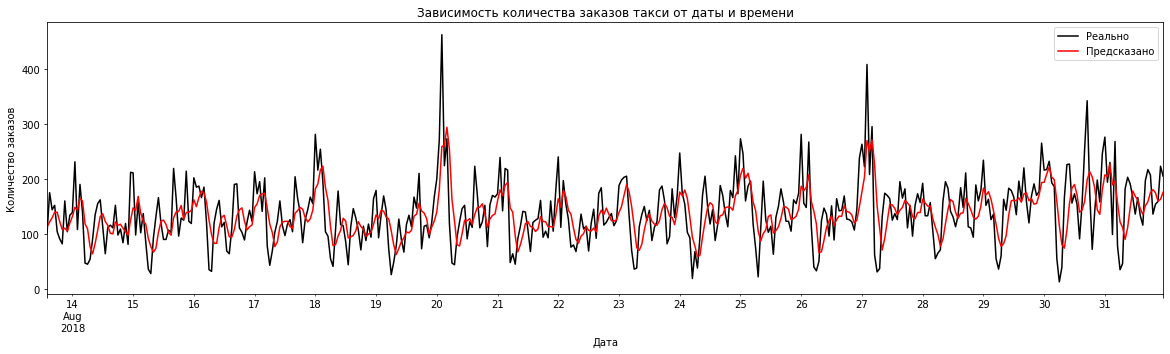

In [24]:
plt.figure(figsize=(20, 5))
y_test.plot(color='black')
pd.Series(y_pred_linreg, index=y_test.index).plot(color='red')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Зависимость количества заказов такси от даты и времени')
plt.legend(('Реально', 'Предсказано'))
plt.show()

Мы видим, что даже простая линейная регрессия уловила основные тренды и сезонности временного ряда.